## Tutorial: mapping snRNA-seq on spatial smFISH data
by Gabriele Scalia (gscalia@broadinstitute.org) and Tommaso Biancalani (tbiancal@broadinstitute.org)
- Healthy adult mouse brain tissue from the primary visual area (VISp).
- snRNAseq data (SmartSeq2) and spatial data (Visium).

In [1]:
# basic imports
import pandas as pd
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import scanpy as sc
import torch
import scipy
import matplotlib.patches as mpatches
from IPython.display import display
import seaborn as sns

# torch imports
from torch.nn.functional import softmax, cosine_similarity, sigmoid

# add `Tangram` to path
import sys
sys.path.append("../") 

# Tangram imports
import mapping.utils
import mapping.mapping_optimizer
import mapping.plot_utils

In [4]:
'Folder where data are stored'
fld = '.'
assert os.path.isdir(fld)

In [5]:
'Load snRNA-seq data (AnnData format)'
path = os.path.join(fld, 'data/visp_sn_tpm_small_0430.h5ad')
adata = sc.read_h5ad(path)
adata.var_names_make_unique()

In [6]:
'Load spatial smFISH data (AnnData format)'
path = os.path.join(fld, 'data/smFISH_anndata.h5ad')
space_data = sc.read_h5ad(path)

/home/gscalia/miniconda3/envs/dev/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
'Compute shared genes between single nuclei and spatial data'
# get matched indices between prior (ie spatial data) and snRNA-seq adata
# `selected_genes` contains (ordered) shared genes'
mask_prior_indices, mask_adata_indices, selected_genes =  mapping.utils.get_matched_genes(
    space_data.var_names, adata.var_names
)
len(selected_genes)  

In [9]:
'Initialize matrixes to run Tangram'
S = np.array(adata[:, mask_adata_indices].X)  # single cells/nuclei matrix
G = np.array(space_data[:, mask_prior_indices].X)  # spatial data matrix
d = np.full(G.shape[0], 1/G.shape[0])  # spatial cell density

In [10]:
'Apply log(1+x) to snRNAseq data (optional)'
S = np.log(1+S)

In [11]:
'Select gpu/cpu for running Tangram'
device = torch.device('cuda:0')  # for gpu
# device = torch.device('cpu') # for cpu

In [12]:
'Define Tangram hyperparameters'
# refer to manuscript for their meaning
hyperparm = {'lambda_d' : 1, 'lambda_g1' : 1, 'lambda_g2' : 0, 'lambda_r' : 0,
            'lambda_count' : 1, 'lambda_f_reg' : 1}

In [13]:
'Define training hyperparameters'
learning_rate = 0.1
num_epochs = 1000

In [14]:
'Create mapping object' 
# Arguments: matrices, device, all hyperaparameters'
mapper = mapping.mapping_optimizer.MapperConstrained(
    S=S, G=G, d=d, device=device, **hyperparm, target_count=G.shape[0]
)

In [15]:
'Train Tangram'
# Arguments: learning rate and the number of epochs.
# The output are the various loss terms (see manuscript)/
# density term, gene-voxel cosine similarity, voxel-gene cosine similarity, count term, F regularizer term
# all loss terms are printed normalizing their weight (hyperaparamete)
output, F_out = mapper.train(learning_rate=learning_rate, num_epochs=num_epochs)

8.41225337353535e-05 0.4695018231868744 nan 1063.4013671875 2434.196533203125
0.01273307204246521 0.9593597054481506 nan 4.41064453125 369.7375793457031
0.011491280049085617 0.9634304046630859 nan 0.181640625 93.63455200195312
0.011287262663245201 0.9641333818435669 nan 0.19482421875 51.650177001953125
0.011222983710467815 0.9644454717636108 nan 0.03125 37.61787414550781
0.011183647438883781 0.9646222591400146 nan 0.0126953125 31.432815551757812
0.011147867888212204 0.9647372364997864 nan 0.06640625 28.050479888916016
0.011121304705739021 0.9648162722587585 nan 0.0595703125 26.036239624023438
0.011110012419521809 0.9648879766464233 nan 0.001953125 24.762975692749023
0.0110978027805686 0.9649391174316406 nan 0.1318359375 23.705326080322266


In [16]:
'Annotation transfer from snRNAseq to spatial data'
# Use `mapping.utils.transfer_annotations_prob_filter`to transfer annotations onto space.
# Here, we transfer subclasses (ie cell types).
df_classes = mapping.utils.one_hot_encoding(adata.obs.subclass)
# Print probability of each voxel (ie cell) being of a certain cell type'
prob_assign = mapping.utils.transfer_annotations_prob_filter(output, F_out, df_classes)
prob_assign.head()

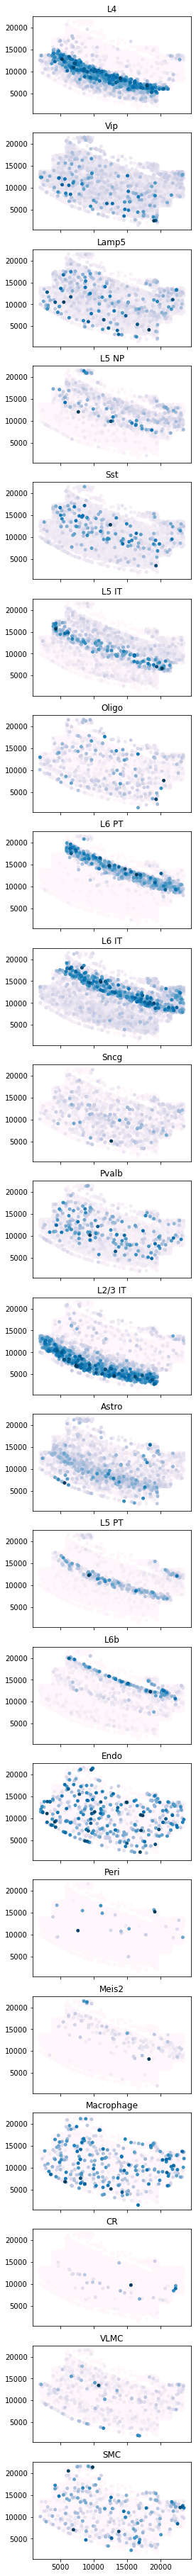

In [18]:
'Print spatial probability maps of cell types'
from mapping.plot_utils import ordered_predictions

fig, axarr = plt.subplots(len(prob_assign.columns), 1, figsize=(4, len(prob_assign.columns)*3), sharex=True, sharey=True) 

for index, i in enumerate(prob_assign.columns):
    xs, ys, preds = ordered_predictions(space_data.obs.x, space_data.obs.y, prob_assign[i])
    axarr[index].scatter(x=xs, y=ys, c=preds, s=15, cmap='PuBu')
    axarr[index].set_title(i)
#fig.savefig('./class_predictions.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)

In [19]:
'Assign the most likely cell type to each cell'
max_assign = prob_assign.idxmax(axis=1)
types_df = pd.DataFrame({'x': space_data.obs.x.values, 'y': space_data.obs.y.values, 'types': max_assign})

(917.1494727137554, 24556.125239306326, 417.49610505086525, 22584.9125971318)

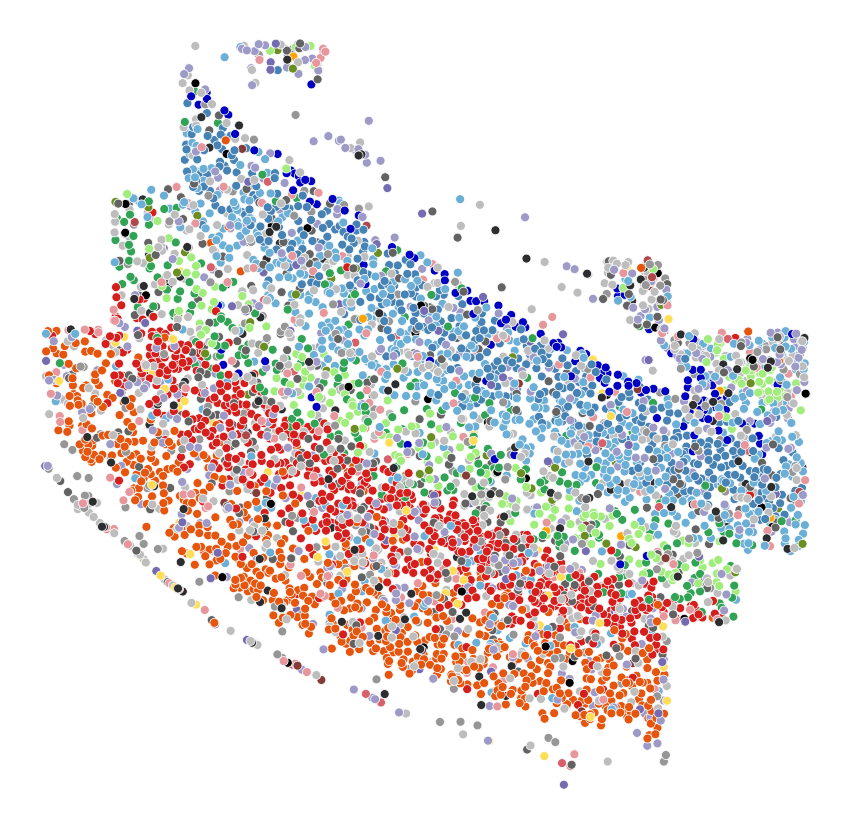

In [20]:
'Visualize spatial map of most-likely cell types'
plt.figure(figsize=(15,15))

sns.scatterplot(x='x', y='y', data=types_df, hue='types', palette=mapping.plot_utils.mapping_colors, legend=False, s=80)
plt.axis('off')
#plt.savefig('sm_fish_predictions.pdf')